In [1]:
# initial setup
%run "../../../common/0_notebooks_base_setup.py"


/Users/csuarezgurruchaga/Desktop/Digital-House/CLASE_28/dsad_2021/common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
pandas=1.1.5 already installed
bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
pytest=6.2.1 already installed
chardet=4.0.0 already installed
psutil=5.7.2 already installed
scipy=1.5.2 already installed
statsmodels=0.12.1 already installed
scikit-learn=0.23.2 already installed
xlrd=2.0.1 already installed
Running command `conda install --yes nltk=3.5.0`... ok
Solving environment: ...working... done

# All requested packages already installed.


unidecode=1.1.1 already installed
pydotplus=2.0.2 already installed
pandas-datareader=0.9.0 already installed
flask=1.1.2 already installed


<img src="../../../common/logo_DH.png" align='left' width=50%/>

# Regresión Logística
## Tabla de Contenidos

- [1. Introducción](#intro)
- [2. Repaso de regresión lineal](#lineal)
- [3. Repaso de probabilidad](#proba)
- [4. Regresión logística](#logistica)
    - [4.1. Regresión logística con Scikit-Learn](#sklearn)
    - [4.2. Estimación de los coeficientes](#coef)
    - [4.3. Umbral de decisión](#umbral)
    - [4.4. Clasificación multiclase](#multiclase)
- [5. Caso de uso](#caso)
    - [5.1. Introducción al problema](#caso_intro)
    - [5.2. Análisis y exploración del dataset](#caso_eda)
    - [5.3. Manipulación de datos](#caso_dummies)
    - [5.4. Ajuste del modelo](#caso_entrenamiento)
    - [5.5. Statsmodels](#caso_stats)
- [6. Documentación](#docs)

<a id="intro"></a>
## Introducción
Hasta ahora nos veníamos concentrando en entrenar, validad y mejorar modelos que permitieran generar una predicción para una observación a partir de un conjunto de variables que la caracterizaban.<br>
<u>Ejemplo</u>: predecir el precio de una propiedad en función de las características de la misma. En este caso la variable objetivo (target) es el valor numérico en dólares o pesos del precio de la propiedad y las variables explicativas son la cantidad de ambientes, los metros cuadrados, el barrio, etc.<br>
Para resolver esta tarea ya vimos algunos modelos como la regresión lineal y distintos tipos de estrategias para validarlos y mejorarlos, como por ejemplo feature engineering y regularización. 
<div id="caja9" style="float:left;width: 100%;">
  <div style="float:left;width: 15%;"><img src="../../../common/icons/para_seguir_pensando.png" style="align:left"/> </div>
  <div style="float:left;width: 85%;"><label><i>Para recordar: ¿Qué es y para qué se usa cada una?</i><br></label></div>
Si bien todo lo visto hasta ahora tiene varias diferencias, ventajas y desventajas, siempre hay algo en común: <b>la variable objetivo es numérica</b>.<br>
Como vimos la clase anterior, existen algunos problemas en los que el objetivo es poder predecir el valor de una <b>variable categórica</b>. Esto implica que tengamos que redifinir (un poco) el problema. El objetivo a grandes rasgos seguirá siendo el mismo: predicir una característica de una observación en función del resto de sus características (variables independientes --> variable objetivo/dependiente).La diferencia es que ahora el resultado de la predicción no puede tomar cualquier valor, sino que está acotado a un número finito de valores posibles. Este tipo de problemas son de <b>clasificación</b>.
##### <u>Ejemplo práctico</u>
Tenemos una serie de artículos de un diario y debemos saber si los mismos pertenecen a la sección de Economía, Deportes o Policiales. Sería muy fácil para una persona leer cada artículo y <i>clasificarlo</i> en función del texto, pero queremos automatizarlo con un modelo de aprendizaje automático. Planteemos el problema:
- Features: el título y el texto del artículo.
- Target: la sección del diario a la que pertenece.

¿Qué es lo que hace que este sea un problema de clasificación? Simplemente el hecho de que la variable objetivo tenga 3 valores posibles: Economía (E), Deportes (D) o Sociedad (S) y ningún otro.<br>
El objetivo del modelo que entrenemos, será <b>estimar la probabilidad P</b> de que el artículo leído pertenezca a cada sección.<br>
Si tenemos 100 artículos de Economía (E), 100 de Deportes (D) y 100 de Sociedad (S) y sacamos uno al azar, tendremos
    
$P(\text{sección=E}) = \frac{1}{3}$, 
$P(\text{sección=D}) = \frac{1}{3}$, 
$P(\text{sección=S}) = \frac{1}{3}$, 
    lo cual no es muy útil. Pero si luego de elegir el artículo al azar, leemos el título que dice "Copa Libertadores", sabemos que las probabilidades serán muy diferentes. Lo que cambia, es que ahora tenemos más información para hacer la clasificación ya que está <b>condicionada</b>. Sería esperable que el modelo genere $P(\text{sección=D}|\text{título="Copa Libertadores"}) = 0.99$
#### Generalizando
A partir del ejemplo anterior, podemos escribir todos los problemas de clasificación como el cálculo de una probabilidad condicional:
$$P(y_{i}=clase_{j}|x_{i}=X) = ¿?$$
<center>¿Cuál es la probabilidad de que la observación $i$ pertenezca a la clase $j$, sabiendo el valor de sus features $x$?</center>



<a id="lineal"></a>
## Repaso de regresión lineal
Recordemos brevemente la regresión lineal. Es un modelo que permite estimar un valor numérico a partir de una combinación lineal del valor de las features:
$$\hat{y_{i}}=\beta_{0}+\beta_{1}·x_{1}+\beta_{1}·x_{1}+\dots+\beta_{p}·x_{p}$$
Donde los $\beta$ se estiman ($\hat{\beta}$) a partir del set de entreamiento. Si tenemos una única feature, la fórmula se reduce al caso de la regresión lineal <i>simple</i>:
$$\hat{y_{i}}=\hat{\beta_{0}}+\hat{\beta_{1}}·x_{1}$$
Intentemos usar esta fórmula para hacer el cálculo de probabilidad que mencionamos anteriormente, utilizando como caso un ejemplo simple en el que hay que debemos entrenar un clasificador binario que permita identificar si una obsevación pertenece a la clase "0" o a la clase "1". Es decir que intentaremos estimar $P(y=1|x)$ con la siguiente fórmula:
$$ P(y=1|x) = \beta_{0}+\beta_{1}·x_{1}$$

In [5]:
#Importamos las bibliotecas que usaremos
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression

Crearemos unos datos de prueba

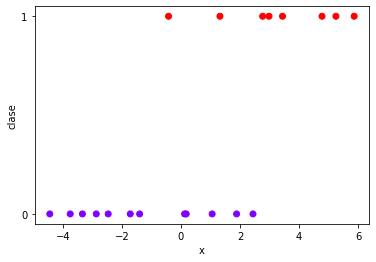

In [6]:
# Definimos la cantidad de datos que crearemos
n = 20
# Seteamos una semilla para obtener resultados repetibles
np.random.seed(0)
# Generamos las observaciones
x = np.linspace(-5,5,n) + np.random.rand(n)
x = x.reshape(-1,1)
# Les asignamos una clase (0 o 1)
y = np.zeros(n)
for i in range(n):
    y[i] = np.random.choice([0,1], size=1, p=[np.exp(-i/n), 1-np.exp(-i/n)])
#Graficamos los datos
plt.scatter(x,y,c=y, cmap='rainbow')
plt.xlabel('x')
plt.ylabel('clase')
plt.yticks([0,1]);

Supongamos que este es nuestro conjunto de datos, donde:
- `x` es un `ndarray` y es la única feature
- `y` es un `ndarray` que contiene la clase a la que pertenece cada observación

Respondé las siguientes preguntas:
- ¿Cuántas observaciones hay?
- ¿Cuántas hay de cada clase?

In [7]:
#Solución
print(x.shape[0])
a=y
a=pd.Series(a)
print(a.value_counts())

20
0.0    12
1.0     8
dtype: int64


A partir del gráfico podemos deducir que cuanto más grande sea el valor de x, más probable es que la observación pertenezca a la clase 1, cuando más chico sea el valor de x, menos probable es que la clase sea 1, y hay un rango intermedio de valores de x para los cuales la clase no está tan claramente definida. Intentemos plasmar eso utilizando una regresión lineal:

In [8]:
# Instanciamos un objeto de la clase LinearRegression
linear_regression = LinearRegression()
# Ajustamos el modelo
linear_regression.fit(x, y)
# Imprimimos los coeficientes
print(linear_regression.intercept_)
print(linear_regression.coef_)

0.33239905882437815
[0.11624173]


Esto significa que $\hat{y}=0.332+ 0.116·x$. Grafiquemos esta recta superpuesta con los datos:

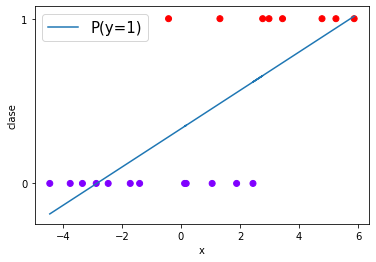

In [9]:
#Graficamos los datos
plt.scatter(x,y,c=y, cmap='rainbow')
plt.xlabel('x')
plt.ylabel('clase')
plt.yticks([0,1])
plt.plot(np.sort(x), linear_regression.predict(np.sort(x)));
plt.legend(["P(y=1)"], fontsize=15);

¡Excelente! Logramos obtener un modelo que se ajusta a lo esperado. Los valores de la recta reflejan la relación entre x y $P(y=1|x=X)$

<b>PAUSA</b><br>
Detengámonos un momento a pensar sobre lo que acabamos de hacer...<br>
Partimos de un dataset que presentaba un problema de clasificación binaria, o sea que $y$ puede valer 0 o 1 para cada observación. Visualizando los datos, vimos que aquellas observaciones con $y=1$ tenían valores de $x$ más grandes y las observaciones con $y=0$ tenían valores de $x$ más pequeños. Luego entrenamos una regresión lineal para intentar reflejar este comportamiento y eso fue lo que obtuvimos.<br>
Pero acá hay algo raro...

In [10]:
# Usá el modelo entrenado para predecir la clase de 2 observaciones nuevas
x_nuevas = np.array([[-4], [11]])

In [11]:
# Solución
linear_regression.predict(x_nuevas)

array([-0.13256788,  1.61105813])

<a id="proba"></a>
### Repaso de probabilidad
Repasemos algunos conceptos claves de las probabilidades.<br>
Para empezar, sabemos que la probabilidad debe estar acotada en el rango [0, 1], es decir que no pueden existir probabilidades negativas ni mayores que 1.<br>
Por otro lado, sabemos que la suma de todas las probabilidades para cada clase posible debe ser 1. Si hay 0.25 de probabilidad de que $y=0$, entonces $P(y=1) = 1-0.25=0.75$

¿Esto se cumple en los casos anteriores?

La respuesta es <b>no</b> y se debe a que la regresión lineal simple tiene como resultado una recta que no está acotada. Puede tomar cualquier valor y esto no nos sirve para estimar una probabilidad. Lo mismo aplica para una regresión lineal múltiple con varias features. 

La conclusión de esta pequeña prueba, es que una regresión lineal no sirve para resolver problemas de clasificación, en los que el objetivo es obtener una estimación de probabilidades condicionales a los features de cada observación.

<a id="logistica"></a>
## Regresión Logística
No todo está perdido. Hay algo que podemos hacer para subsanar los problemas que mencionamos recién.<br>
Pensemos momentáneamente en la siguiente función:
$$
\sigma(z) = \frac{1}{1+e^{-z}}
$$
Esta función es conocida como <i>función sigmoidea</i> y nos será de gran utilidad en unos momentos.

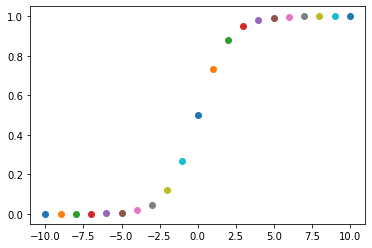

In [12]:
# Ejercicio: graficá la función sigmoidea para valores de z entre -10 y 10
val=np.linspace(-10,10,21)
for x in val:
    y=1/(1+np.exp(-x))
    plt.scatter(x=x,y=y)

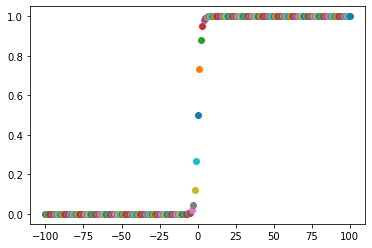

In [13]:
# Ejercicio: graficá la función sigmoidea para valores de z entre -100 y 100
val2=np.linspace(-100,100,201)
for x in val2:
    y=1/(1+np.exp(-x))
    plt.scatter(x=x,y=y)

Vemos que esta función sigue cumpliendo con lo esperado para nuestro problema:
- Se tienen valores más grandes para valores más grandes de z
- Se tienen valores más chicos para valores más chicos de z
- Se tienen valores "intermedios" para valores "intermedios" de z

Y suma una gran ventaja: <b>la función sigmoidea está acotada en el rango (0,1).</b> No importa cuánto valga z, $\sigma(z)$ siempre será mayor que 0 y menor que 1. Ya empezamos a ver por qué esta función nos será de utilidad para estimar probabilidades.<br>
Quedan algunas cosas por resolver antes de poder utilizar esta función para estimar probabilidades. Para empezar, la función sigmoidea recibe una variable $z$ que es única y nosotros sabemos que nuestros features $x$ pueden ser varios (es decir que $x$ es un <i>vector</i> $\bar{x}$). Acá es donde entra la regresión en <b>regresión</b> logística:
- Ya sabemos obtener un valor numérico a partir de un conjunto de features utilizando la regresión lineal
- Dicho valor no está acotado entre 0 y 1, pero la función sigmoidea sí
- Si calculamos la función sigmoidea del valor obtenido con la regresión lineal, obtendremos un número entre 0 y 1 que podemos usar para estimar probabilidades.

Formalmente escrito:
$$
\sigma(z) = \frac{1}{1+e^{-z}} \text{ está acotada en (0,1)}
$$
<br>
$$
z = \beta_{0}+\beta_{1}·x_{1}+\beta_{1}·x_{1}+\dots+\beta_{p}·x_{p} 
$$
<br>
$$
P(y_{i}=1|x=X) = \frac{1}{1+e^{-(\beta_{0}+\beta_{1}·x_{1}+\beta_{1}·x_{1}+\dots+\beta_{p}·x_{p})}}
$$
<br>
Prestemos atención a la última ecuación sin perder de vista nuestro objetivo: poder estimar la probabilidad $P(y=1|x=X)$.<br>
Estamos utilizando los features $x$ para obtener un valor numérico $z$ que no está acotado. Luego estamos calculando la sigmoidea de $z$, $\sigma(z)$ para poder interpretar ese valor como una probabilidad. Ésto es lo que se conoce como <b>regresión logística</b>

<a id="sklearn"></a>
### Regresión logística con Scikit-Learn
Scikit-Learn ya tiene implementada una clase de regresión logística con todos los métodos que ya conocemos (`.fit()`, `.predict()`) con algunos agregados que iremos viendo más adelante. Esto hace que la metodología de trabajo sea la misma de siempre:

In [14]:
# Importamos la clase
from sklearn.linear_model import LogisticRegression
# Instanciamos un objeto de esa clase
logistic_regression = LogisticRegression()
# Ajustamos esta instancia con los datos de entrenamiento
logistic_regression.fit(x, y)

ValueError: Expected 2D array, got scalar array instead:
array=100.0.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Una vez que tenemos el modelo entrenado, podemos utilizarlo para hacer predicciones

In [ ]:
logistic_regression.predict(x)

Observamos que las predicciones obtenidas son <b>las clases de pertenencia de cada observación</b> según el modelo. Pero si estábamos hablando de estimar probabilidades, ¿por qué el modelo genera etiquetas y no estima probabilidades?<br>
La realidad es que el modelo hace ambas cosas:
- Estima las probabilidades de pertenecer a cada clase
- Compara esas probabilidades con un umbral

Si para una observación, $P(y=1|x=X)\ge0.5 \text{ entonces } \hat{y}=1$ <br>
Si para una observación, $P(y=1|x=X)<0.5 \text{ entonces } \hat{y}=0$<br>
De esta manera se logra clasificar a las observaciones en función de las probabilidades de que pertenezca a una clase. Para visualizar estas probabilidades, debemos usar el método `.predict_proba()`.

In [ ]:
logistic_regression.predict_proba(x)

Vemos que el output de `.predict_proba(x)` es un `ndarray` de forma (`n_obsevaciones`, `n_clases`). Como en este ejemplo tenemos 20 observaciones y 2 clases posibles (0 o 1), ocurre que

In [ ]:
logistic_regression.predict_proba(x).shape

Donde la columna 0 es la probabilidad de pertenencia a la clase 0 y la columna 1 es la probabilidad de pertenencia a la clase 1.<br>
Pregunta relámpago: ¿cuánto debe valer la suma de cada fila? Verificarlo con código.

In [ ]:
# Sumamos el valor de cada columna para cada fila
logistic_regression.predict_proba(x).sum(axis=1)

Si nos quedamos sólamente con la columna 1, podremos hacer la comparación que mencionamos recién:

In [ ]:
# Nos quedamos sólamente con la columna 1
prob_1 = logistic_regression.predict_proba(x)[:,1]
# Comparamos con 0.5
prob_1 >= 0.5

In [ ]:
# Comparamos con el método .predict()
(prob_1 >= 0.5) == logistic_regression.predict(x)

Vemos que es lo mismo para todos los casos obtener predicciones con el método `.predict()` que obtener la estimación de las probabilidades con `.predict_proba()` y luego compararlo con el valor de umbral 0.5.<br>
En la práctica a veces es necesario modificar el valor de umbral por diversos motivos, por lo que no hay que perder de vista que los clasificadores en Scikit-Learn tienen el método `.predict_proba()` que nos permite jugar manualmente con el valor de umbral. Si no es necesario modificar este valor, utilizando `.predict()` obtendremos los mismo resultados que umbralizando con 0.5.

Una vez que ya tenemos las etiquetas puestas por el modelo (es decir $\hat{y}$) debemos comparar esas predicciones con los valores reales ($y$)

In [ ]:
y_pred = logistic_regression.predict(x)
y == y_pred

<b>Ejercicio:</b> calcular el <i>accuracy</i> del modelo con este set de datos. Recordemos la fórmula:
$$
\text{Accuracy} = \frac{\text{predicciones correctas}}{\text{casos totales}}
$$

In [ ]:
# Usando numpy
(y == y_pred).sum() / len(y)

In [ ]:
# Usando Scikit-Learn
from sklearn.metrics import accuracy_score
accuracy_score(y, y_pred)

<a id="coef"></a>
#### Estimación de los coeficientes
Recordemos que el objetivo de la regresión logística es poder estimar
$$
P(y_{i}=1|x=X) = \frac{1}{1+e^{-(\beta_{0}+\beta_{1}·x_{1}+\beta_{1}·x_{1}+\dots+\beta_{p}·x_{p})}}
$$
Esto implica que, al igual que en la regresión lineal, debemos encontrar los valores de los $\beta$ que ajusten mejor a los datos. En este caso, como tenemos un sólo feature ($x$), la ecuación se reduce a 
$$
P(y_{i}=1|x=X) = \frac{1}{1+e^{-(\beta_{0}+\beta_{1}·x)}}
$$
dónde deberemos hallar $\hat{\beta_{0}}$ y $\hat{\beta_{1}}$. Éstos coeficientes se encuentran en los atributos `.intercept_` y `.coef_` de la instancia del modelo entrenado.

In [ ]:
logistic_regression.intercept_

In [ ]:
logistic_regression.coef_

¿Por qué estos valores no coinciden con los estimados por la regresión lineal?<br>
Recordemos que la estimación de los coeficientes en la regresión lineal minimiza el error cuadrático medio (MSE).<br>
¿Los coeficientes de la regresión logística tienen el mismo objetivo?<br>
La respuesta es no. En el caso de los clasificadores se utilizan otras métricas y con el siguiente ejemplo veremos por qué:<br>
- Al estimar el precio de una casa obtuvimos un valor de USD200.000, cuando su valor real era USD210.000. El error fue de 210.000 - 200.000 = USD10.000
- Al clasificar una imágen con animales obtuvimos la categoría "elefante",  cuando su etiqueta real era "jirafa". ¿Cómo cuantificamos el error? Sólo sabemos que la predicción fue incorrecta.

En los casos de clasificación debemos pensar nuevas formas de evaluar los modelos y hacernos la pregunta ¿qué esperamos de un buen clasificador?. La respuesta es bastante simple: un buen clasificador nos dará $P(y=1|x=X)$ muy cercanos a 1 para todas las observaciones donde $y=1$ y muy cercanos a cero para todas las observaciones donde $y=0$. Esto puede expresarse con la siguiente expresión matemática:
$$
L = \prod_{i:y_i=1}P(y=1|x=X) · \prod_{i:y_i=0}(1-P(y=1|x=X))
$$
La primer productoria hace referencia a los casos donde $y=1$ por lo que esperamos tener probabilidades cercanas a 1 y la segunda productoria hace referencia a los casos donde $y=0$ por lo que esperamos probabilidades cercanas a 0. A esta expresión se la conoce como <b>verosimilitud</b> o <b>likelihood</b> y es lo que trataremos de maximizar.<br>
Si manipulamos un poco la fórmula anterior, la podemos reescribir de la siguiente manera:
$$
L = \prod_{i=1}^{m} P(y_i=1|x_i=X)^{y_i} · (1-P(y_i=1|x_i=X))^{1-y_i}
$$
$$
log(L) = log(\prod_{i=1}^{m} P(y_i=1|x_i=X)^{y_i} · (1-P(y_i=1|x_i=X))^{1-y_i})
$$
$$
LL = \sum_{i=1}^{m} y_i·log(P(y_i=1|x_i=X))+(1-y_i)·log((1-P(y_i=1|x_i=X)))
$$
A esta última expresión se la conoce como <b>log-likelihood</b>, que es el logaritmo de la verosimilitud.<br>
Analicemos los posibles casos con los que nos podemos encontrar y veamos cómo quedan los términos de la sumatoria:
- <u>y = 1</u>

Reemplacemos $y_i = 1$ en la fórmula de LL y analicemos un sólo caso (sin la sumatoria)
$$
1·log(P(y_i=1|x_i=X))+(1-1)·log((1-P(y_i=1|x_i=X)))
$$
<br>
$$
1·log(P(y_i=1|x_i=X))+{(0)·log((1-P(y_i=1|x_i=X)))}
$$
<br>
$$
log(P(y_i=1|x_i=X))
$$
<br>
Dado que $y_i = 1$, uno esperaría que $P(y_i=1|x_i=X)$ sea muy cercano a 1, por lo que $log(P(y_i=1|x_i=X))$ sería $log(\sim1)$, que es muy cercano a 0. <br>
Si el clasificador es malo y genera $P(y_i=1|x_i=X)$ cercanas a 0, $log(P(y_i=1|x_i=X))$ sería $log(\sim0)$, que tiende a $-\infty$.

- <u>y = 0</u>

Reemplacemos $y_i = 0$ en la fórmula de LL y repitamos el análisis
$$
0·log(P(y_i=1|x_i=X))+(1-0)·log((1-P(y_i=1|x_i=X)))
$$
<br>
$$
0·log(P(y_i=1|x_i=X))+{(1)·log((1-P(y_i=1|x_i=X)))}
$$
<br>
$$
log((1-P(y_i=1|x_i=X)))
$$
<br>
Dado que $y_i = 0$, uno esperaría que $P(y_i=1|x_i=X)$ sea muy cercano a 0, por lo que $log((1-P(y_i=1|x_i=X)))$ sería $log(1-\sim0)$, que es muy cercano a 0. <br>
Si el clasificador es malo y genera $P(y_i=1|x_i=X)$ cercanas a 1, $log((1-P(y_i=1|x_i=X)))$ sería $log(1-\sim1)$, que tiende a $-\infty$.
<br>
En resumen:
- si el clasificador predice probabilidades cercanas al caso real, se suman valores cercanos a 0
- si el clasificador predice lo contrario al caso real, se suman valores muy grandes con signo negativo

El problema que Scikit-Learn resuelve por nosotros, es <b>encontrar los $\beta$ que maximicen la verosimilitud</b>, acercando las predicciones a los valores reales de las observaciones. Este proceso es conocido como MLE, o Maximum Likelihood Estimation.

<br>
<b>NOTA IMPORTANTE</b><br>
Al igual que en la regresión lineal, la función de costo puede ser modificada para reducir el sobreajuste agregando un término de regularización $\lambda\|\beta\|^2$. Scikit-Learn hace esto por defecto con el hiperparámetro C = 1/$\lambda$. Para valores más grandes de C, menor grado de regularización y viceversa.



<a id="umbral"></a>
### Umbral de decisión
Como mencionamos anteriormente, el modelo genera una probabilidad de pertenencia a cada clase (un número real entre 0 y 1) que luego es comparada con un umbral de decisión, generalmente 0.5, para etiquetar cada observación con una clase. Veamos qué implicancias tiene esto:

In [ ]:
# Generaremos 30 muestras con 2 features cada una y una clase de pertenencia
n=30
np.random.seed(1)
x1 = np.random.rand(n)*10-5
x2 = np.random.rand(n)*10-5
y = (x1-x2 >0).astype(int)
plt.figure(figsize=(10,8))
sns.scatterplot(x=x1,y=x2, hue=y, s=100)
plt.legend(['Clase 1', 'Clase 0'], loc='upper left')
plt.xlabel('x1')
plt.ylabel('x2');

<b>Ejercicio:</b> ajustá un modelo de regresión logística al nuevo conjunto de datos e imprimí los coeficientes encontrados.

In [ ]:
# Unificamos las features en un unico array
x = np.array([x1,x2]).T
# Ajustamos el modelo
logistic_regression.fit(x, y)
# Imprimimos los coeficientes
print(logistic_regression.coef_)
print(logistic_regression.intercept_)

Obtuvimos un coeficiente para cada feature y uno para la ordenada al origen. Esto significa que las probabilidades se calcularán como
$$
P(y=1|x=X)=\sigma(z)=\sigma(\beta_0+\beta_1·x_1+\beta_2·x_2)
$$<br>
$$
P(y=1|x=X)=\frac{1}{1+e^{-(\beta_0+\beta_1·x_1+\beta_2·x_2)}}
$$

Y todas aquellas probabilidades que sean mayores a 0.5 serán etiquetadas como 1 y todas las que sean menores serán etiquetadas como 0. El umbral de decisión se ubica cuando $\sigma(z)=0.5$ y, como se ve en el gráfico, esto ocurre para $z=0$. <i>Bonus: demostrarlo analíticamente</i>

In [ ]:
def sigmoid(x):
    return (1 / (1 + np.exp(-x)))

plt.figure(figsize=(10,8))
plt.plot(np.linspace(-8,8,100), sigmoid(np.linspace(-8,8,100)), 'r');
plt.ylabel('sigmoide(z)');
plt.xlabel('z');
plt.ylim([-0.2,1.2])
plt.yticks([0,0.5,1])
plt.xticks([0],['0'])
plt.grid(color='k', linestyle='dashdot', linewidth=1)

Recordando que $z = \beta_0+\beta_1·x_1+\beta_2·x_2$, podemos hacer las siguientes operaciones:
$$
z = \beta_0+\beta_1·x_1+\beta_2·x_2
$$<br>
$$
0 = \beta_0+\beta_1·x_1+\beta_2·x_2
$$<br>
$$
\frac{-\beta_0-\beta_1·x_1}{\beta_2} = x_2
$$<br>
$$
x_2 = - x_1 · \frac{\beta_1}{\beta_2} - \frac{\beta_0}{\beta_2}
$$<br>
La última expresión tiene la forma de una recta de $x_2$ en función de $x_1$. Si reemplazamos los coeficientes obtenidos y graficamos esa recta sobre el conjunto de datos, obtenemos:

In [ ]:
# Graficamos los datos
plt.figure(figsize=(10,8))
sns.scatterplot(x = x1, y = x2, hue = y, s = 100)
plt.xlabel('x1')
plt.ylabel('x2');
# Graficamos la recta
eje_1 = np.linspace(-5,5, 10)
beta_0 = logistic_regression.intercept_[0]
beta_1 = logistic_regression.coef_[0][0]
beta_2 = logistic_regression.coef_[0][1]
eje_2 = -eje_1*beta_1/beta_2 - beta_0/beta_2
plt.plot(eje_1, eje_2, c='r');
plt.legend(['umbral', 'Clase 1', 'Clase 0'], loc='upper left');

Observamos que la recta obtenida es la que mejor separa las dos clases.

<a id="multiclase"></a>
### Clasificación multiclase
Hasta ahora estuvimos analizando un caso en el que los datos tenían sólo dos etiquetas posibles. "Azul" vs "naranja", "violeta" vs "rojo", 0 vs 1. Esto casos son de clasificación <b>binaria</b> y vimos cómo ajustar un modelo de regresión logística para resolver este problema y cómo interpretar los resultados del ajuste. Existe un gran abanico de problemas de clasificación en los que hay más de 2 formas posibles de etiquetar las observaciones y estos son llamados problemas de <b>clasificación multiclase</b>.<br>
Supongamos que tenemos una imágen y queremos clasificar si hay un animal en ella. Estamos ante un caso de clasificación <b>binaria</b>, ya que sólo hay 2 posibilidades: hay animal, o no hay animal. Si lo que deseamos es saber qué animal hay en la foto, es un caso de clasificación <b>multiclase</b> ya que existen varias etiquetas que le podemos asignar a la foto ("perro", "gato", "elefante", etc. o "sin animal"). También puede ocurrir que en la imagen haya más de un animal y estos casos son denominados <b>multietiqueta</b>, ya que a cada observación le puede tocar más de una etiqueta.<br>
Las implementaciones de Scikit-Learn vienen preparadas para trabajar de manera nativa con problemas multiclase y en el caso de la regresión logística el problema se encara de una manera muy simple. Si tenemos 4 etiquetas posibles, digamos "rojo" "celeste", "verde" y "violeta", podemos plantear 4 problemas binarios por separado:
- ¿es "rojo"?
- ¿es "azul"?
- ¿es "verde"?
- ¿es "violeta"?

Generalizando, un problema multiclase con N etiquetas, podemos plantearlo como N problemas binarios. Veamos un ejemplo:

In [ ]:
# Generamos un dataset de pruebas
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=100, # generamos 100 muestras
                           n_features=2, n_redundant=0, # con 2 features explicativas
                           n_classes=4, # que pueden pertenecer a 4 clases distintas
                           n_clusters_per_class=1, # donde cada clase comprende un cluster
                           random_state=1) # y fijamos una semilla para obtener resultados repetibles
# Visualizamos los datos
plt.figure(figsize=(8,8))
sns.scatterplot(x = X[:,0], y = X[:,1], hue=y, palette='rainbow')
plt.xlabel('x1')
plt.ylabel('x2');

Utilicemos la implementación de Scikit-Learn para resolver el problema

In [ ]:
logistic_regression.fit(X,y)

En función de los valores encontrados en `y`, el objeto `logistic_regression` determina automáticamente la cantidad de clases posibles y genera las etiquetas correspondientes.

In [ ]:
logistic_regression.predict(X)

Antes de ejecutar las siguientes celdas, ¿qué resultado esperás obtener?

In [ ]:
logistic_regression.predict_proba(X)

In [ ]:
logistic_regression.predict_proba(X).sum(axis=1)

¿Y qué pasa con los coeficientes e interceptos de este modelo? 

In [ ]:
logistic_regression.coef_

In [ ]:
logistic_regression.intercept_

Cada una de las 4 clases tiene sus propios coeficientes e interceptos. Generalizando:
- `.coef_` tendrá forma (N_clases, N_features)
- `.intercept_` tendrá forma (N_clases,)

En estos casos, en lugar de comparar las probabilidades (`.predict_proba`) con un valor de umbral, la etiqueta elegida será la mayor de todas las probabilidades para esa observación.

In [ ]:
logistic_regression.predict_proba(X).argmax(axis=1)

In [ ]:
all(logistic_regression.predict(X) == logistic_regression.predict_proba(X).argmax(axis=1))

<a id="caso"></a>
## Caso de uso
Ahora veremos un ejemplo práctico en el que usaremos la regresión logística para clasificar admisiones de estudiantes a distintas universidades.

<a id="caso_intro"></a>
### Introducción al problema
Estamos interesados en entender cómo influyen algunas variables en las probabilidades de admisión de alumnos a distintas universidades. Las variables con las que trabajaremos son las siguientes:
- GRE: graduate record exam
- GPA: grade point average
- Prestigio de la institución de proveniencia

Contamos con un dataset de 400 pedidos de ingreso a 10 universidades distintas en la que cada pedido está etiquetado como 1 (admitido) o 0 (no admitido).

<a id="caso_eda"></a>
### Análisis y exploración del dataset

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('../Data/binary.csv')
df.head()

Observamos las 3 variables cuya influencia deseamos analizar y la variable objetivo (admit). Valores más altos de `gre` y `gpa` indican mejores resultados, mientras que los valores más bajos de `prestige` indican mayor prestigio de la institución de procedencia.

In [ ]:
# Balance del dataset
df['admit'].value_counts(normalize=True)

El 31% de los estudiantes son admitidos. Veamos un poco más en detalle cómo se distribuyen

In [ ]:
sns.pairplot(df, hue='admit')

Veamos cómo se distribuyen las observaciones en el plano gpa-gre para los distintos niveles de prestigio.

In [ ]:
g = sns.FacetGrid(df, col="prestige", hue="admit")
g.map(plt.scatter, "gpa", "gre", alpha=.7)
g.add_legend();

Para ver de forma un poco más clara, podemos hacer histogramas agrupando según el valor de admit. 

In [ ]:
axes_ = df.boxplot(by = 'admit', return_type = 'axes', whis = [5,95], layout = (1, 3), figsize = (16,5));
for ax,col in zip(axes_,['gpa','gre','prestige']):
    ax.set_ylim(df[col].min()/1.1,df[col].max()*1.1)

Podemos ver que hay ligeras modificaciones en la mediana que podrían predecir el valor de admit.

<a id="caso_dummies"></a>
### Manipulación de datos
Al igual que ocurre con la regresión lineal, en la regresión logística necesitamos trabajar con variables numéricas. Es por esto que debemos transformar las variables categóricas en variables dummy.<br>
En este caso la única variable categórica que tenemos es el prestigio de la institución de proveniencia, que está expresada en forma numérica. A mayor prestigio, más bajo el número. Si esta variable ya es numérica, ¿debemos transformarla en dummies?<br>
Recordemos que la regresión logística realiza una combinación lineal de las features. Esto implica que un GPA de 3, contribuye el doble que un GPA de 1.5 (de ahí lo lineal). ¿Podemos afirmar que una institución con prestigio 2 es el doble de prestigiosa que una con prestigio 4? La realidad es que no podemos asumir que el prestigio viene dado en una escala lineal y por lo tanto no podemos tratar la variable como numérica y debemos crear dummies para cada nivel de prestigio.

In [ ]:
# Creamos dummies para prestige
dummies_prestige = pd.get_dummies(df['prestige'], drop_first=True, prefix='prestige')
dummies_prestige.head()

In [ ]:
# Unimos los dataframes
df = pd.concat([df, dummies_prestige], axis=1)
df.head()

Ya podemos armar la matriz de features y el vector objetivo

In [ ]:
X = df[['gre','gpa','prestige_2','prestige_3','prestige_4']]
y = df["admit"]

Y separar los datos en train y test

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=12)

<a id="caso_entrenamiento"></a>
### Ajuste del modelo
Recordemos que la implementación de la regresión logística de Scikit-Learn aplica regularización por defecto con el hiperparámetro C, por lo que será importante estandarizar los datos antes de fitear el modelo.

In [ ]:
# Utilizamos sklearn para estandarizar la matriz de Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [ ]:
# Ajustamos el modelo
logistic_regression.fit(X_train_scaled, y_train)
# Y visualizamos los coeficientes
print(logistic_regression.coef_)
print(logistic_regression.intercept_)

In [ ]:
# Hacemos predicciones con el modelo entrenado
y_train_pred = logistic_regression.predict(X_train_scaled)
y_test_pred = logistic_regression.predict(scaler.transform(X_test)) # Notar que debemos escalar los datos de testeo antes de realizar predicciones

In [ ]:
# Elaboramos la matriz de confusión
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_test_pred)
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True)
plt.ylabel('Verdaderos')
plt.xlabel('Predichos');

In [ ]:
# Calculemos el accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_test_pred)

<a id="caso_stats"></a>
### Uso de `statsmodels`
Recordemos que Scikit-Learn es sólo una de las tantas bibliotecas que ofrecen implementaciones de modelos de aprendizaje automático. `statsmodels` es otra de ellas que ofrece un enfoque más estadístico. En esta sección utilizaremos las implementaciones de `statsmodels` para la regresión logística y repetiremos el análisis.

In [ ]:
import statsmodels.api as sm

`statsmodels` pide que explicitemos si el modelo debe estimar un término independiente $\beta_0$ o no.

In [ ]:
X_train_stats = sm.add_constant(X_train_scaled)

In [ ]:
# Instanciamos la clase
logit = sm.Logit(y_train, X_train_stats)
# Fiteamos el modelo
result = logit.fit()
# Imprimimos el resumen
print(result.summary2())

Mirando el summary obtenido, ¿qué podemos decir sobre los coeficientes $\beta_1$, $\beta_2$ y $\beta_3$?

No son significativos, para esa variable target

In [ ]:
#Hagamos predicciones
X_test_stats = sm.add_constant(scaler.transform(X_test))
# Obtenemos las probabilidades y las comparamos con 0.5 
y_pred_stats = result.predict(X_test_stats) > 0.5
# Generamos la matriz de confusión
sns.heatmap(confusion_matrix(y_test, y_pred_stats), annot=True)
plt.ylabel('Verdaderos')
plt.xlabel('Predichos');

In [ ]:
# Calculamos el accuracy
accuracy_score(y_test, y_pred_stats)

<a id="docs"></a>
### Documentación
- [Regresión logística con Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [Regresión logística con Statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.html#statsmodels.discrete.discrete_model.Logit)

In [ ]:
logistic_regression.classes_